
Found 4432 images belonging to 4 classes.
Found 572 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


Epoch 1/50


139/139 [==============================] - 212s 1s/step - loss: 0.6106 - accuracy: 0.7541 - val_loss: 0.3757 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 2/50
139/139 [==============================] - 185s 1s/step - loss: 0.3786 - accuracy: 0.8518 - val_loss: 0.2894 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 3/50
139/139 [==============================] - 177s 1s/step - loss: 0.3148 - accuracy: 0.8784 - val_loss: 0.2412 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 4/50
139/139 [==============================] - 185s 1s/step - loss: 0.2622 - accuracy: 0.9030 - val_loss: 0.2586 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 5/50
139/139 [==============================] - 185s 1s/step - loss: 0.2247 - accuracy: 0.9188 - val_loss: 0.1869 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 6/50
139/139 [==============================] - 183s 1s/step - loss: 0.2122 - accurac

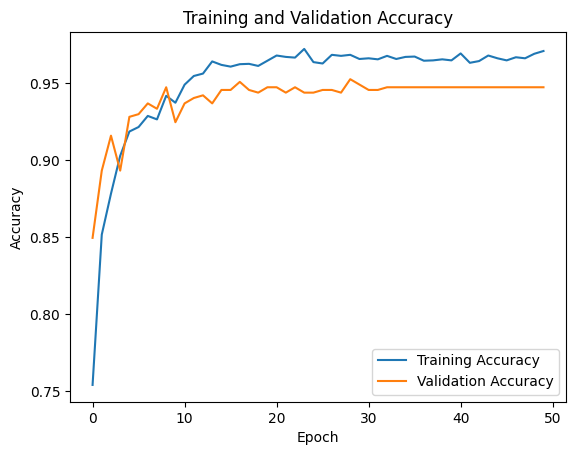

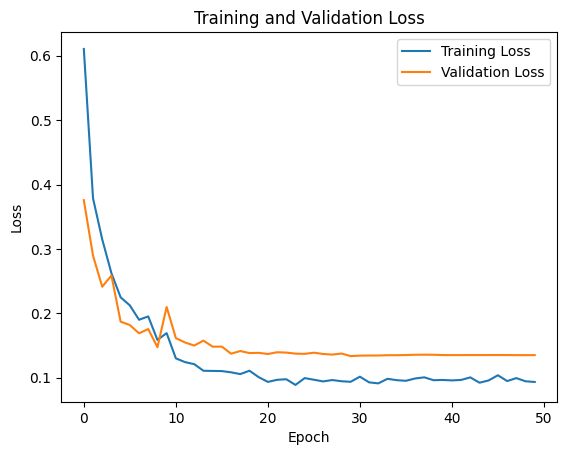

5/5 [==============================] - 4s 745ms/step - loss: 0.1880 - accuracy: 0.9236

Test Loss: 0.1880, Test Accuracy: 0.9236
5/5 [==============================] - 6s 586ms/step


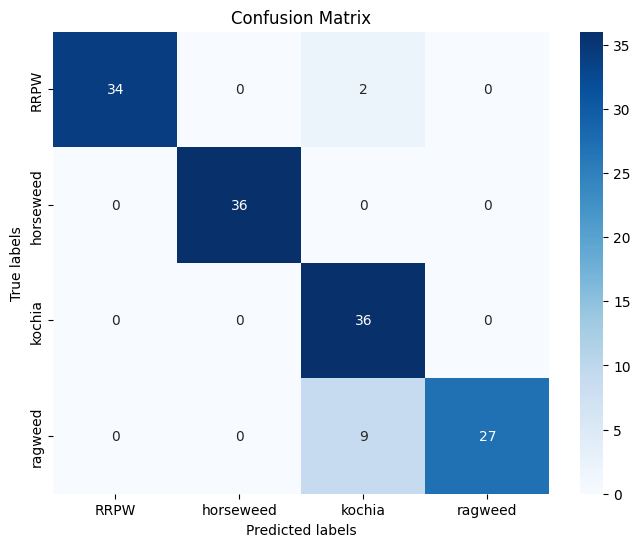

              precision    recall  f1-score   support

        RRPW       1.00      0.94      0.97        36
   horseweed       1.00      1.00      1.00        36
      kochia       0.77      1.00      0.87        36
     ragweed       1.00      0.75      0.86        36

    accuracy                           0.92       144
   macro avg       0.94      0.92      0.92       144
weighted avg       0.94      0.92      0.92       144


Class: RRPW
True Positives: 34, True Negatives: 108, False Positives: 0, False Negatives: 2

Class: horseweed
True Positives: 36, True Negatives: 108, False Positives: 0, False Negatives: 0

Class: kochia
True Positives: 36, True Negatives: 97, False Positives: 11, False Negatives: 0

Class: ragweed
True Positives: 27, True Negatives: 108, False Positives: 0, False Negatives: 9


In [1]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt

# Set the paths to your training, validation, and test datasets
# Set the paths to your training, validation, and test datasets
train_data_dir = r"C:\Users\DELL\Desktop\Weed Aug\Training"
val_data_dir = r"C:\Users\DELL\Desktop\Weed Aug\Validation"
test_data_dir = r"C:\Users\DELL\Desktop\Weed Aug\Testing"

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # MobileNetV2-specific preprocessing
)

# Data Augmentation for Validation (only normalization)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data Augmentation for Testing (only normalization)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Assuming 24 classes, adjust as needed
num_classes = 4

# Load pre-trained MobileNetV2 without the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a model with custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Class Weights Calculation
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Learning Rate Schedule
def lr_schedule(epoch):
    return 1e-3 * (0.1 ** (epoch // 10))

lr_scheduler = LearningRateScheduler(lr_schedule)


# Model Training
num_epochs = 50  # Adjust as needed

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[lr_scheduler]
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Model Evaluation on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities for test set
Y_pred = model.predict(test_generator)
# Convert probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate TP, TN, FP, FN
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

for i in range(len(class_names)):
    print(f"\nClass: {class_names[i]}")
    print(f"True Positives: {TP[i]}, True Negatives: {TN[i]}, False Positives: {FP[i]}, False Negatives: {FN[i]}")
